# Implement a custom pipeline

GPJax does not support sharing parameters across mean and kernel. Therefore, a custom model must be defined (in lieu of the traditional posterior) as well as a custom objective function (which is a modified `gpx.objectives.ConjugateMLL`) to perform a fit (obtain optimised posterior).

In [55]:
import jax
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
from gpjax.base import param_field
from dataclasses import dataclass, field
import tensorflow_probability.substrates.jax.bijectors as tfb
from gpjax.distributions import GaussianDistribution

from gpjax.typing import (
    Array,
    ScalarFloat,
)
from jaxtyping import (
    Float,
    Num,
)

import cola
from cola.ops import (
    Dense,
    LinearOperator,
)


import sys
import os
abs_path = os.path.abspath('../src')
sys.path.append(abs_path)
from p53_data import JAXP53_Data, dataset_3d, generate_test_times
from kernels import latent_kernel
from custom_gps import p53_posterior
from plotter import plot_gp

from gpjax.dataset import Dataset

import beartype.typing as tp
Kernel = tp.TypeVar("Kernel", bound="gpjax.kernels.base.AbstractKernel")
CustomModel = tp.TypeVar("Model", bound="p53_model")

import optax as ox
key = jr.PRNGKey(42)

In [56]:
# define model
@dataclass
class p53_model(gpx.base.Module):
    """
    Implementation of p53 model from Lawrence et al. 2006
    """
    ####### Define parameters

    # Sensitivities of the genes
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)

    l: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )
    
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True)

    
    # Define mean function (TODO: change zero mean)
    def mean_function(self, x: Num[Array, "N D"]) -> Float[Array, "N O"]:
        #return jnp.ones((x.shape[0], 1)) * 0

        f = jnp.array(x[:,2:], dtype=int)
    
        num_genes = 5
        block_size = (x.shape[0] // num_genes)
        mean = (self.true_b / self.true_d).reshape(-1, 1)
        mean = mean.repeat(block_size, jnp.newaxis).reshape(-1,1)

        return mean * f
    
    # Define kernel
    def kernel(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t, t_prime).T
        )

        return final_kernel
    
    def kernel_xx(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()
    
    def kernel_xf(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = gene_xpr - latent_force

        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        
        return kxf.squeeze()
    
    def kernel_ff(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
            
        t = t[0].reshape(-1)
        t_prime = t_prime[0].reshape(-1)

        sq_dist = jnp.square(t.reshape(-1, 1) - t_prime)
        sq_dist = jnp.divide(sq_dist, 2 * self.l.reshape((-1, 1)))

        K = jnp.exp(-sq_dist)

        return K.squeeze() 
    
    # Helper functions
    def h(self, j: Float[Array, " O"], k: Float[Array, " O"], t1: Float[Array, " O"], t2: Float[Array, " O"]) -> ScalarFloat:

        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2
    
    
    # Calculate cross-covariance
    def cross_covariance(
        self, kernel: Kernel, x: Float[Array, "N D"], y: Float[Array, "M D"]
    ) -> Float[Array, "N M"]:
        cross_cov = jax.vmap(lambda x: jax.vmap(lambda y: kernel(x, y))(y))(x)
        return cross_cov

    def gram(self, kernel: Kernel, x: Float[Array, "N D"]) -> LinearOperator:
        Kxx = self.cross_covariance(kernel, x, x)
        return cola.PSD(Dense(Kxx))


    ############################
    # Define predict method
    ############################
    def latent_predict(
        self, test_inputs: Num[Array, "N D"], train_data: JAXP53_Data
    ) -> GaussianDistribution:
    
        x, y, variances = dataset_3d(train_data)
        t = test_inputs
        jitter = 1e-3

        mean_x = self.mean_function(x)
        mean_t = self.mean_function(t)

        diag_variances = jnp.diag(variances.reshape(-1))
        Kxx = self.gram(self.kernel, x)
        Kxx += diag_variances
        Kxx += cola.ops.I_like(Kxx) * jitter
        K_inv = cola.inv(Kxx)

        Kxf = self.cross_covariance(self.kernel, x, t)
        KfxKxx = jnp.matmul(Kxf.T, K_inv.to_dense())
        mean = mean_t + jnp.matmul(KfxKxx, y - mean_x)

        Kff = self.gram(self.kernel, t)
        Kff += cola.ops.I_like(Kff) * jitter

        var = Kff - jnp.matmul(KfxKxx, Kxf)
        var = jnp.diag(jnp.diag(var.to_dense()))
        var += cola.ops.I_like(var) * jitter * 1e-4

        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), var)

In [57]:
class CustomConjMLL(gpx.objectives.AbstractObjective):
    def step(self, model: CustomModel, train_data: Dataset) -> ScalarFloat:
        x, y = train_data.X, train_data.y

        obs_noise = jnp.array([1.0e-3], dtype=jnp.float64)**2
        mx = model.mean_function(x)

        # Σ = (Kxx + Io²) = LLᵀ
        Kxx = model.gram(model.kernel, x)
        Kxx += cola.ops.I_like(Kxx) * 1e-4
        Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
        Sigma = cola.PSD(Sigma)

        # p(y | x, θ), where θ are the model hyperparameters:
        mll = GaussianDistribution(jnp.atleast_1d(mx.squeeze()), Sigma)

        return self.constant * (mll.log_prob(jnp.atleast_1d(y.squeeze())).squeeze())

In [58]:
p53_data = JAXP53_Data(replicate=0, data_dir='../data')
training_times, gene_expressions, variances = dataset_3d(p53_data)

dataset_train = gpx.Dataset(training_times, gene_expressions)

testing_times = generate_test_times()

In [59]:
dataset_train = gpx.Dataset(training_times, gene_expressions)
custom_posterior = p53_model()
loss = CustomConjMLL()

In [60]:
trained_model, history = gpx.fit(model=custom_posterior, objective=loss, train_data=dataset_train, optim=ox.adam(0.01), key=key, num_iters=100)

Running: 100%|██████████| 100/100 [00:01<00:00, 65.20it/s, Value=-385968.54]


In [61]:
trained_model

p53_model(true_s=Array([0.51533593, 0.81792649, 0.48113288, 1.67558933, 0.50014114],      dtype=float64), true_d=Array([0.78269962, 0.95281928, 0.83949333, 0.16906926, 0.80994427],      dtype=float64), l=Array(3.10270513, dtype=float64), true_b=Array([0.01904285, 0.03008229, 0.01700008, 0.16571779, 0.01829953],      dtype=float64))

In [62]:
latent_dist = trained_model.latent_predict(testing_times, p53_data)

In [63]:
latent_mean = latent_dist.mean()
latent_std = latent_dist.stddev()

In [64]:
f = p53_data.f_observed.squeeze()

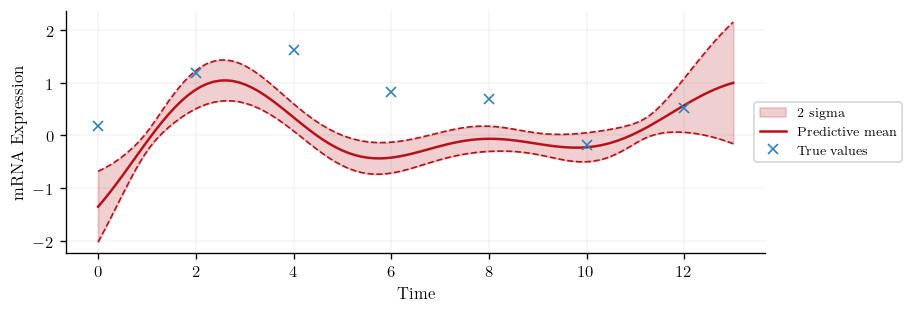

In [65]:
plot_gp(testing_times, latent_dist, y_scatter=f)